<a href="https://colab.research.google.com/github/paul-emile1/TIPE/blob/main/TIPE_sp%C3%A9_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**INTRODUCTION ET DEBUT DU TRAITEMENT DES DONNEES**
Création d'un classement de tennis grâce à un algortime de Perron-Frobenius.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from datetime import timedelta
from datetime import *
from random import *
import copy
from math import *
from time import *
color = sns.color_palette()
sns.set_style('darkgrid')

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chargement du data_atpset/supression des colonnes avec des données manquantes

data_atp = pd.read_csv('/content/drive/MyDrive/TIPE/DATASET_ATP_FINAL.csv')
data_atp = data_atp.dropna()
data_atp = data_atp.reset_index(drop=True)

data_myrank = pd.read_csv('/content/drive/MyDrive/TIPE/DATA_MYRANK_FINAL.csv')
data_myrank = data_myrank.dropna()
data_myrank = data_myrank.reset_index(drop=True)

In [ ]:
#Convertissement des données en type int

data_atp['Player1Rank'] = pd.to_numeric(data_atp['Player1Rank'])
data_atp['Player2Rank'] = pd.to_numeric(data_atp['Player2Rank'])
data_atp['Player1Sets'] = pd.to_numeric(data_atp['Player2Sets'])
data_atp['Date'] = pd.to_datetime(data_atp.Date)

data_myrank['Player1Rank'] = pd.to_numeric(data_myrank['Player1Rank'])
data_myrank['Player2Rank'] = pd.to_numeric(data_myrank['Player2Rank'])
data_myrank['Player1Sets'] = pd.to_numeric(data_myrank['Player2Sets'])
data_myrank['Date'] = pd.to_datetime(data_myrank.Date)




**Quelques modifications sur DATA_MYRANK**


*   j'actualise la colonne winner
*   j'actualise les colonnes best_rank



In [ ]:
###peut-être une meilleure manière d'encoder les joueurs
index_joueurs_stats = {}
#Dictionnaire contenant le nom des joueurs comme une clé [player_index,x,y,z,t,w]
#x : nombres_de_matchs_gagnés
#y : nombres_de_matchs_joués
#z : meilleur classement en carrière (on le fixe par défaut à 3000)
# t : date du dernier match
# w : liste des h2h contre les autres joueurs
i=0

for player in data_myrank['Player1'].unique():
    if player not in index_joueurs_stats.keys():
        index_joueurs_stats[player] = [i,0,0,3000,0]
        i+=1
for player in data_myrank['Player2'].unique():
    if player not in index_joueurs_stats.keys():
        index_joueurs_stats[player] = [i,0,0,3000,0]
        i+=1

print('Nombre exact de joueurs : ',i)

Nombre exact de joueurs :  279


In [ ]:
data_myrank['Best_rank_p1'] = 0
data_myrank['Best_rank_p2'] = 0

for c, row in data_myrank.iterrows():
  p1 = row[6]
  p2 = row[11]
  if row[5]<index_joueurs_stats[p1][3]:
    data_myrank.at[c, 'Best_rank_p1'] = row[5]
    index_joueurs_stats[p1][3] = row[5]
  else:
    data_myrank.at[c, 'Best_rank_p1'] = index_joueurs_stats[p1][3]

  if row[10]<index_joueurs_stats[p2][3]:
    data_myrank.at[c, 'Best_rank_p2'] = row[10]
    index_joueurs_stats[p2][3] = row[10]
  else:
    data_myrank.at[c, 'Best_rank_p2'] = index_joueurs_stats[p2][3]

**On mélange aléatoirement P1 et P2**

In [ ]:
import pandas as pd
import numpy as np

def randomize_players_and_winner(df):
    # Sélectionner les colonnes correspondant aux caractéristiques des joueurs
    player_cols = ['Player1', 'B365Player1', 'B365Player2', 'Player1Rank', 'Player2Rank',
                   'Player2', 'elo_P1', 'elo_P2', 'Best_rank_p1', 'Best_rank_p2',
                   'ratio_p1_saison', 'ratio_p2_saison', 'ratio_p1_carrière', 'ratio_p2_carrière']

    # Créer une copie du data_atpFrame pour ne pas modifier l'original
    df_copy = df.copy()

    # Pour chaque ligne du data_atpFrame
    for index, row in df_copy.iterrows():
        # Inverser aléatoirement les colonnes correspondant aux caractéristiques des joueurs
        if np.random.rand() < 0.5:
            # Inverser les colonnes
            df_copy.at[index, 'Winner'] = 1 - df_copy.at[index, 'Winner']
            for col in player_cols:
                col_index = df_copy.columns.get_loc(col)
                opponent_col = col.replace('1', '2').replace('2', '1')
                opponent_col_index = df_copy.columns.get_loc(opponent_col)
                df_copy.iloc[index, col_index], df_copy.iloc[index, opponent_col_index] = df_copy.iloc[index, opponent_col_index], df_copy.iloc[index, col_index]

    return df_copy

data_atp = randomize_players_and_winner(data_atp)
data_myrank = randomize_players_and_winner(data_myrank)


**Dernière modifications des datasets...**

In [ ]:
# Suppression des colonnes qui ne seront plus utiles au modèle
data_atp = data_atp.drop(['Player1','Player2','Player1Sets','Player2Sets','Date'],axis = 1)
data_myrank = data_myrank.drop(['Player1','Player2','Player1Sets','Player2Sets','Date'],axis = 1)

In [ ]:
data_atp['Winner'] = pd.to_numeric(data_atp['Winner'])
data_myrank['Winner'] = pd.to_numeric(data_myrank['Winner'])

In [ ]:
data_atp = data_atp.drop(['Series'], axis = 1)
data_myrank = data_myrank.drop(['Series'], axis = 1)

In [ ]:
data_atp['Player1Pts'] = data_atp['Player1Pts'].astype('int64')
data_atp['Player2Pts'] = data_atp['Player2Pts'].astype('int64')
data_atp['Player1Rank'] = data_atp['Player1Rank'].astype('int64')
data_atp['Player2Rank'] = data_atp['Player2Rank'].astype('int64')
data_atp['elo_P1'] = data_atp['elo_P1'].astype('int64')
data_atp['elo_P2'] = data_atp['elo_P2'].astype('int64')


data_myrank['Player1Pts'] = data_myrank['Player1Pts'].astype('int64')
data_myrank['Player2Pts'] = data_myrank['Player2Pts'].astype('int64')
data_myrank['Player1Rank'] = data_myrank['Player1Rank'].astype('int64')
data_myrank['Player2Rank'] = data_myrank['Player2Rank'].astype('int64')
data_myrank['elo_P1'] = data_myrank['elo_P1'].astype('int64')
data_myrank['elo_P2'] = data_myrank['elo_P2'].astype('int64')

###**DIVISION DES DATASETS POUR L'ENTRAINEMENT ET LE TEST**

In [ ]:
def pre_processing(df):
  df = df.dropna()

  X = df.drop(['Winner'], axis = 1)
  y = df['Winner']

  return X, y

In [ ]:
from sklearn.model_selection import train_test_split
trainset_atp, testset_atp = train_test_split(data_atp, test_size = 0.2, random_state = 45)
trainset_myrank, testset_myrank = train_test_split(data_myrank, test_size = 0.2, random_state = 45)

In [ ]:
X_train_atp, y_train_atp = pre_processing(trainset_atp)
X_train_myrank, y_train_myrank = pre_processing(trainset_myrank)


In [ ]:
X_test_atp, y_test_atp = pre_processing(testset_atp)
X_test_myrank, y_test_myrank = pre_processing(testset_myrank)

In [ ]:
print(y_test_myrank.shape)

(2642,)


###**MODELISATION**

In [ ]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score



**Comparaison de différents modèles par cross validation**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split,StratifiedKFold

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis

from sklearn import model_selection


X = X_train_atp
Y = y_train_atp

seed = 42

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA',QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(125, n_jobs=-1)))
models.append(('CART', DecisionTreeClassifier(max_depth=10)))
models.append(('NB', GaussianNB()))

models.append(('RandomForest',RandomForestClassifier( n_estimators=100, n_jobs=-1)))
models.append(('MLP',MLPClassifier(alpha=0.000001)))
models.append(('ADABoost',AdaBoostClassifier()))


results = []
scoring = {'accuracy': make_scorer(accuracy_score),
          'precision_score': make_scorer(precision_score),
          'recall_score' : make_scorer(recall_score),
          'f1_score' : make_scorer(f1_score)}
names = []
for name, model in models:

    stratifiedKFold = model_selection.StratifiedKFold(n_splits=10, random_state=seed,shuffle = True)
    cv_results = model_selection.cross_validate(model, X, Y, cv=stratifiedKFold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg ='-------------------------------------------------------------------------------------------------------------\n'
    msg = "Model : %s \n" % (name)
    msg = msg +'\n'

    msg =  msg + "Accuracy :  %f (%f)\n" % (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std())
    msg =  msg + "Precision score :  %f (%f)\n" % (cv_results['test_precision_score'].mean(), cv_results['test_precision_score'].std())
    msg =  msg + "Recall score :  %f (%f)\n" % (cv_results['test_recall_score'].mean(), cv_results['test_recall_score'].std())
    msg =  msg + "F1 score :  %f (%f)\n" % (cv_results['test_f1_score'].mean(), cv_results['test_f1_score'].std())
    msg = msg + '------------------------------------------------------------------------------------------------------------\n'
    print(msg)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Model : LR 

Accuracy :  0.673218 (0.020969)
Precision score :  0.671643 (0.023136)
Recall score :  0.663463 (0.029479)
F1 score :  0.667215 (0.022475)
------------------------------------------------------------------------------------------------------------

Model : LDA 

Accuracy :  0.666545 (0.022389)
Precision score :  0.666270 (0.022738)
Recall score :  0.651256 (0.028131)
F1 score :  0.658571 (0.024286)
------------------------------------------------------------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/disc

Model : QDA 

Accuracy :  0.645795 (0.017871)
Precision score :  0.648343 (0.023200)
Recall score :  0.622418 (0.046180)
F1 score :  0.633871 (0.024286)
------------------------------------------------------------------------------------------------------------

Model : KNN 

Accuracy :  0.630256 (0.021092)
Precision score :  0.626149 (0.021549)
Recall score :  0.624796 (0.031371)
F1 score :  0.625216 (0.023883)
------------------------------------------------------------------------------------------------------------

Model : CART 

Accuracy :  0.645795 (0.013197)
Precision score :  0.643041 (0.019754)
Recall score :  0.641063 (0.046479)
F1 score :  0.640610 (0.021389)
------------------------------------------------------------------------------------------------------------

Model : NB 

Accuracy :  0.658958 (0.019970)
Precision score :  0.652564 (0.021132)
Recall score :  0.663094 (0.021580)
F1 score :  0.657677 (0.019549)
----------------------------------------------------------

KeyboardInterrupt: 

**GRID SEARCH CV**

**RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Création du premier modèle avec le dataset ATP
rf_atp = RandomForestClassifier()

# Création du grid search pour le premier modèle
grid_search_atp = GridSearchCV(estimator=rf_atp, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entraînement du grid search pour le premier modèle
grid_search_atp.fit(X_train_atp, y_train_atp)

# Meilleurs hyperparamètres pour le premier modèle
best_params_atp = grid_search_atp.best_params_

# Meilleur modèle pour le premier modèle
best_model_atp = grid_search_atp.best_estimator_

# Score du meilleur modèle pour le premier modèle
best_score_atp = grid_search_atp.best_score_

# Affichage des résultats pour le premier modèle
print("Meilleurs hyperparamètres pour le modèle avec classement ATP:", best_params_atp)
print("Score avec les meilleurs hyperparamètres pour le modèle avec classement ATP:", best_score_atp)

# Création du deuxième modèle avec votre propre classement
rf_personnel = RandomForestClassifier()

# Création du grid search pour le deuxième modèle
grid_search_personnel = GridSearchCV(estimator=rf_personnel, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entraînement du grid search pour le deuxième modèle
grid_search_personnel.fit(X_train_myrank, y_train_myrank)

# Meilleurs hyperparamètres pour le deuxième modèle
best_params_personnel = grid_search_personnel.best_params_

# Meilleur modèle pour le deuxième modèle
best_model_personnel = grid_search_personnel.best_estimator_

# Score du meilleur modèle pour le deuxième modèle
best_score_personnel = grid_search_personnel.best_score_

# Affichage des résultats pour le deuxième modèle
print("\nMeilleurs hyperparamètres pour le modèle avec votre propre classement:", best_params_personnel)
print("Score avec les meilleurs hyperparamètres pour le modèle avec votre propre classement:", best_score_personnel)


Meilleurs hyperparamètres pour le modèle avec classement ATP: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Score avec les meilleurs hyperparamètres pour le modèle avec classement ATP: 0.6674588665447898

Meilleurs hyperparamètres pour le modèle avec votre propre classement: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Score avec les meilleurs hyperparamètres pour le modèle avec votre propre classement: 0.6512390969808471


In [ ]:
random_forest_myrank = RandomForestClassifier(max_depth = 10, min_samples_leaf = 3, min_samples_split = 5, n_estimators =  25)
random_forest_myrank.fit(X_train_myrank,y_train_myrank)
print(random_forest_myrank.score(X_test_myrank,y_test_myrank))
print(random_forest_myrank.score(X_train_myrank,y_train_myrank))

# Prédire les probabilités pour le modèle avec votre propre classement
probas_myrank = random_forest_myrank.predict_proba(X_test_myrank)[:, 1]
predictions_myrank = random_forest_myrank.predict(X_test_myrank)


random_forest_atp = RandomForestClassifier(max_depth = 10, min_samples_leaf = 4, min_samples_split = 10, n_estimators =  200)
random_forest_atp.fit(X_train_atp,y_train_atp)
print(random_forest_atp.score(X_train_atp,y_train_atp))
print(random_forest_atp.score(X_test_atp,y_test_atp))
# Prédire les probabilités pour le modèle avec classement ATP
probas_atp = random_forest_atp.predict_proba(X_test_atp)[:, 1]
predictions_atp = random_forest_atp.predict(X_test_atp)


0.6775170325510976
0.7857278061707363
0.7744972577696526
0.6706871345029239


"Lucidité des modèles"

L'écart moyen entre les deux courbes est : 0.03123581057269014


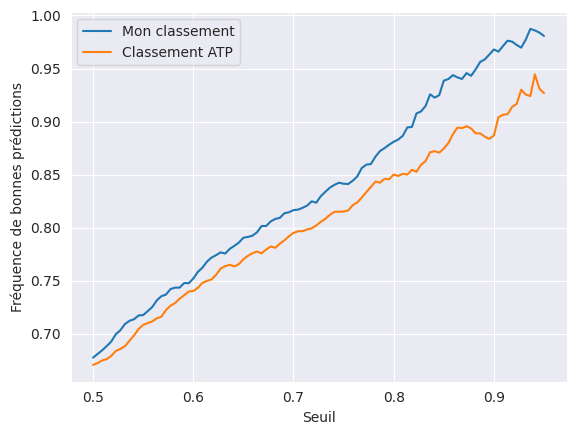

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Définir une liste de seuils
seuils = np.linspace(0.5, 0.95, 100)

# Initialiser une liste pour stocker les fréquences de bonnes prédictions
freq_bonnes_predictions_myrank = []

# Pour chaque seuil, calculer la fréquence de bonnes prédictions
for seuil in seuils:
    # Filtrer les prédictions avec des probabilités éloignées de 0,5
    indices = ((probas_myrank < 1-seuil) | (probas_myrank > seuil)).flatten()

    # Sélectionner les prédictions et les vraies étiquettes correspondantes
    score_filtre = accuracy_score(y_test_myrank[indices], predictions_myrank[indices])
    freq_bonnes_predictions_myrank.append(score_filtre)



# Initialiser une liste pour stocker les fréquences de bonnes prédictions
freq_bonnes_predictions_atp = []

# Pour chaque seuil, calculer la fréquence de bonnes prédictions
for seuil in seuils:
    # Filtrer les prédictions avec des probabilités éloignées de 0,5
    indices = ((probas_atp < 1-seuil) | (probas_atp > seuil)).flatten()

    # Sélectionner les prédictions et les vraies étiquettes correspondantes
    score_filtre = accuracy_score(y_test_atp[indices], predictions_atp[indices])
    freq_bonnes_predictions_atp.append(score_filtre)


freq_bonnes_predictions_atp,freq_bonnes_predictions_myrank = np.array(freq_bonnes_predictions_atp), np.array(freq_bonnes_predictions_myrank)
ecart = np.abs(freq_bonnes_predictions_myrank - freq_bonnes_predictions_atp)
# Calculer l'écart moyen
ecart_moyen = np.mean(ecart)

print(f"L'écart moyen entre les deux courbes est : {ecart_moyen}")

# Tracer la courbe de la fréquence de bonnes prédictions en fonction des seuils
plt.plot(seuils, freq_bonnes_predictions_myrank, label = 'Mon classement')
plt.plot(seuils, freq_bonnes_predictions_atp, label = 'Classement ATP')
plt.xlabel('Seuil')
plt.ylabel('Fréquence de bonnes prédictions')
plt.grid(True)
plt.legend()
plt.show()




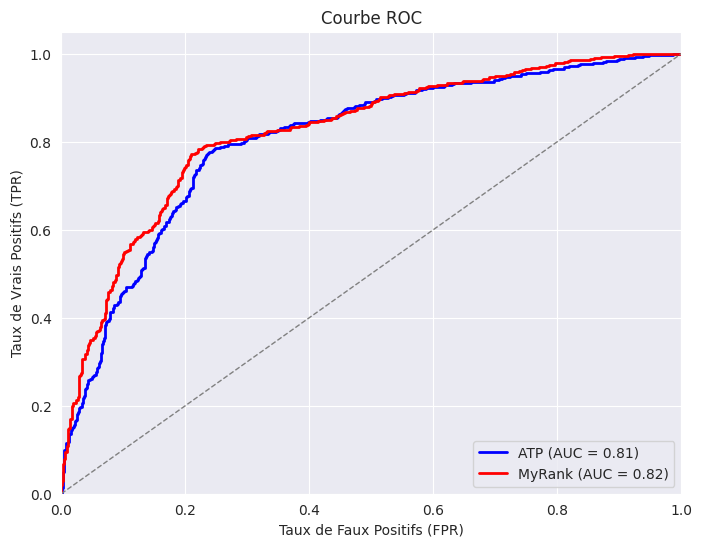

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
seuil_min = 0.35
seuil_max= 0.65
# Filtrer les prédictions en utilisant les seuils de probabilité
indices_atp = ((probas_atp < seuil_min) | (probas_atp > seuil_max)).flatten()
indices_myrank = ((probas_myrank < seuil_min) | (probas_myrank > seuil_max)).flatten()

# Sélectionner les probabilités et les vraies étiquettes correspondantes
probas_atp_filtre = probas_atp[indices_atp]
probas_myrank_filtre = probas_myrank[indices_myrank]
y_test_filtre_atp = y_test_atp[indices_atp]  # Étiquettes pour le modèle avec le classement ATP
y_test_filtre_myrank = y_test_myrank[indices_myrank]  # Étiquettes pour le modèle avec votre classement

# Calculer les taux de faux positifs (FPR) et les taux de vrais positifs (TPR) pour chaque modèle
fpr_atp, tpr_atp, _ = roc_curve(y_test_filtre_atp, probas_atp_filtre)
fpr_myrank, tpr_myrank, _ = roc_curve(y_test_filtre_myrank,probas_myrank_filtre)

# Calculer l'aire sous la courbe ROC (AUC) pour chaque modèle
auc_atp = auc(fpr_atp, tpr_atp)
auc_myrank = auc(fpr_myrank, tpr_myrank)

# Tracer les courbes ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_atp, tpr_atp, color='blue', lw=2, label='ATP (AUC = %0.2f)' % auc_atp)
plt.plot(fpr_myrank, tpr_myrank, color='red', lw=2, label='MyRank (AUC = %0.2f)' % auc_myrank)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()


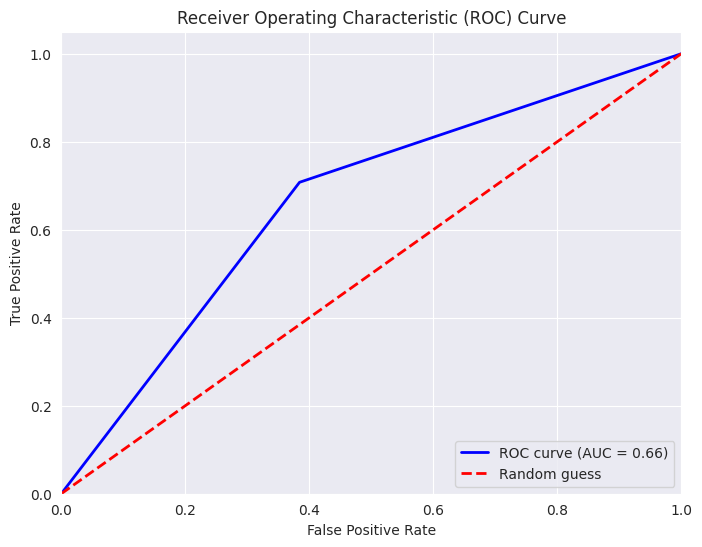

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Supposons que y_test contient les vraies étiquettes et y_pred contient les prédictions de votre modèle
# Remarque : y_pred doit contenir les probabilités de la classe positive

# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_test_atp, predictions_atp)

# Calculer l'AUC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Définir un seuil
seuil = 0.51

# Prédire les classes pour le modèle avec classement ATP en utilisant le seuil
predictions_atp = (probas_atp >= seuil).astype(int)

# Prédire les classes pour le modèle avec votre propre classement en utilisant le seuil
predictions_myrank = (probas_myrank >= seuil).astype(int)

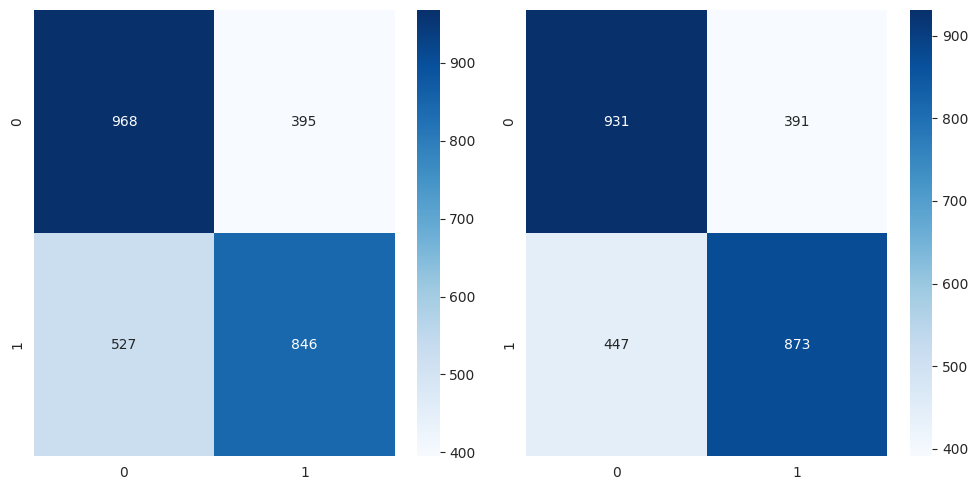

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de confusion pour le modèle avec classement ATP
conf_matrix_atp = confusion_matrix(y_true=y_test_atp, y_pred=predictions_atp)

# Calculer la matrice de confusion pour le modèle avec votre propre classement
conf_matrix_myrank = confusion_matrix(y_true=y_test_myrank, y_pred=predictions_myrank)
# Afficher les matrices de confusion
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_atp, annot=True, fmt='d', cmap='Blues')
#plt.title('Matrice de confusion - Modèle avec classement ATP')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_myrank, annot=True, fmt='d', cmap='Blues')
#plt.title('Matrice de confusion - Modèle avec votre propre classement')

plt.tight_layout()
plt.show()


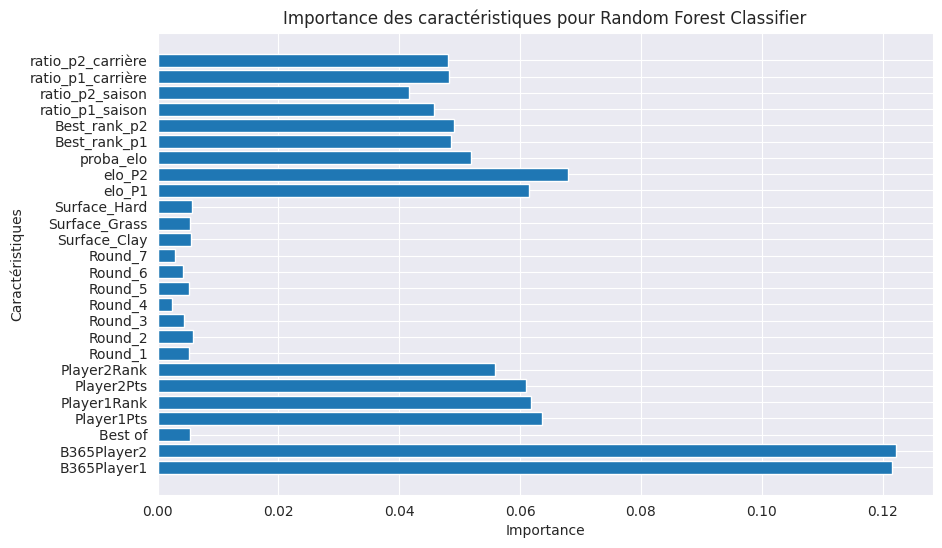

In [ ]:
feature_importance = random_forest_myrank.feature_importances_

# Obtention des noms de caractéristiques
feature_names = X_train_myrank.columns  # Supposons que vos données X_train soient un DataFrame Pandas avec des colonnes nommées

# Création d'un graphique pour visualiser l'importance des caractéristiques
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.title('Importance des caractéristiques pour Random Forest Classifier')
plt.show()